## Load data

In [ ]:
#@markdown ---
#@markdown ## **⚠️❗Ejecute esta celda para descargar Eye diseases dataset⚠️❗**
#@markdown ### Esta celda creara la carpeta ```/content/eye_diseases_data/dataset```

!pip install -qq gdown
!gdown -qq "https://drive.google.com/u/1/uc?id=1JimffPZ5B8fCGd4YxqaaoQf8rLlZWAeg&export=download" -O /eye_images.zip
!mkdir /content/eye_diseases_data/
!unzip -qq /eye_images.zip -d /content/eye_diseases_data/
!rm -r /eye_images.zip

print('Done!')
#@markdown ----


Done!


In [ ]:
!ls /content/eye_diseases_data/dataset/ | wc -l


4


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2, glob, pathlib
from PIL import Image
from tqdm import tqdm

from sklearn.metrics import confusion_matrix, accuracy_score

import torch
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision import transforms as T


In [ ]:
image_transforms = T.Compose([\
                              T.Resize((128,128)),
                              T.RandomPerspective(distortion_scale=0.0, p=1),
                              #T.Pad(padding=3),
                              T.ColorJitter(brightness=0.5),
                              T.ColorJitter(saturation=0.5),
                              T.ColorJitter(contrast=0.5),
                              T.ColorJitter(hue=0.2),
                              T.ToTensor()])


In [ ]:
images = datasets.ImageFolder(root='/content/eye_diseases_data/dataset', transform=image_transforms)


In [ ]:
class_names = images.classes
print(class_names)

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


In [ ]:
len(images)

4217

In [ ]:
train_size = int(0.8 * len(images))
test_size = len(images) - train_size
train_data, test_data = torch.utils.data.random_split(images, [train_size, test_size])
print(train_size, test_size)

3373 844


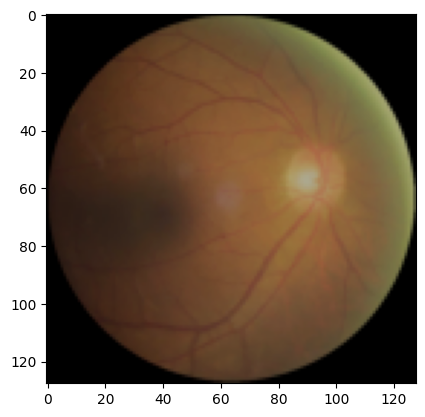

In [ ]:
plt.imshow(train_data[1][0].numpy().transpose(1,2,0))

In [ ]:
# @title
import matplotlib.pyplot as plt
from collections import Counter

# Obtenemos las etiquetas del conjunto de prueba
test_labels = [label for _, label in test_data.dataset.imgs]

# Filtramos las etiquetas del conjunto de prueba usando los índices de 'test_data.indices'
test_labels = [test_labels[i] for i in test_data.indices]

# Contamos las instancias de cada clase en el conjunto de prueba
test_class_counts = Counter(test_labels)

# Ordenamos el diccionario por clases para una mejor visualización
test_class_counts = dict(sorted(test_class_counts.items()))

# Extraemos las clases y sus respectivas cuentas
test_classes = list(test_class_counts.keys())
test_counts = list(test_class_counts.values())

# Convertimos los índices de las clases a los nombres reales usando el atributo 'classes' del dataset original
class_names = [test_data.dataset.classes[i] for i in test_classes]

# Visualizamos la distribución en el conjunto de prueba
plt.figure(figsize=(6, 4))
plt.bar(class_names, test_counts, color='skyblue')
plt.xlabel('Clases')
plt.ylabel('Número de imágenes en el conjunto de prueba')
plt.title('Distribución de clases en el conjunto de prueba')
plt.xticks(rotation=45)
plt.show()


In [ ]:
batch_size = 200
learning_rate = 1e-3
epochs = 50

In [ ]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [ ]:
trainBatch = next(iter(train_loader))
valBatch = next(iter(test_loader))

In [ ]:
#print (trainBatch[0].shape, trainBatch[1].shape)


for i, (batch_X, batch_y) in enumerate(train_loader):
  #
  print (batch_X.shape, batch_y.shape)

torch.Size([200, 3, 128, 128]) torch.Size([200])
torch.Size([200, 3, 128, 128]) torch.Size([200])
torch.Size([200, 3, 128, 128]) torch.Size([200])
torch.Size([200, 3, 128, 128]) torch.Size([200])
torch.Size([200, 3, 128, 128]) torch.Size([200])
torch.Size([200, 3, 128, 128]) torch.Size([200])
torch.Size([200, 3, 128, 128]) torch.Size([200])
torch.Size([200, 3, 128, 128]) torch.Size([200])
torch.Size([200, 3, 128, 128]) torch.Size([200])
torch.Size([200, 3, 128, 128]) torch.Size([200])
torch.Size([200, 3, 128, 128]) torch.Size([200])
torch.Size([200, 3, 128, 128]) torch.Size([200])
torch.Size([200, 3, 128, 128]) torch.Size([200])
torch.Size([200, 3, 128, 128]) torch.Size([200])
torch.Size([200, 3, 128, 128]) torch.Size([200])
torch.Size([200, 3, 128, 128]) torch.Size([200])
torch.Size([173, 3, 128, 128]) torch.Size([173])


##Model

In [ ]:
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    # nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),nn.ReLU(),
    # nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),

    nn.Linear(in_features=128*8*8, out_features=128),nn.ReLU(),
    nn.Linear(in_features=128, out_features=64),nn.ReLU(),
    nn.Linear(in_features=64, out_features=4)#, nn.ReLU(),
    # nn.Linear(in_features=64, out_features=32), nn.ReLU(),
    # nn.Linear(in_features=32, out_features=16), nn.ReLU(),
    # nn.Linear(in_features=16, out_features=8), nn.ReLU(),
    # nn.Linear(in_features=8, out_features=4)

)

summary(model, input_size=(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             448
              ReLU-2         [-1, 16, 128, 128]               0
         MaxPool2d-3           [-1, 16, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]           4,640
              ReLU-5           [-1, 32, 64, 64]               0
         MaxPool2d-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          18,496
              ReLU-8           [-1, 64, 32, 32]               0
         MaxPool2d-9           [-1, 64, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]          73,856
             ReLU-11          [-1, 128, 16, 16]               0
        MaxPool2d-12            [-1, 128, 8, 8]               0
          Flatten-13                 [-1, 8192]               0
           Linear-14                  [

In [ ]:
!nvidia-smi

Mon Nov 13 14:42:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    28W /  70W |  13749MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
torch.cuda.empty_cache()

##Loss and optimizer

In [ ]:
loss = nn.CrossEntropyLoss()
optimizer =torch.optim.Adam(model.parameters(), lr=learning_rate)

#model.cuda()
#loss.cuda

##Training

In [ ]:
losses = []
progress = tqdm(range(epochs), ncols=100)

for epoch in progress:

  batch_losses = 0
  for batch_i, (batch_X, batch_y) in enumerate(train_loader):

    #batch_X = batch_X.cuda()
    #batch_y = batch_y.cuda()


    ### Training ###

    optimizer.zero_grad()

    predictions = model(batch_X)

    batch_loss = loss(predictions, batch_y)

    batch_loss.backward()

    optimizer.step()

    ##---------------------------------------##


    batch_losses += batch_loss.item()

  epoch_loss = batch_losses / len(train_loader)
  losses.append(epoch_loss)

  progress.set_description('[Epoch: {0}/{1}] [Loss: {2:0.5f}]'.format(epoch, epochs, epoch_loss))


[Epoch: 49/50] [Loss: 0.22509]: 100%|████████████████████████████| 50/50 [1:39:50<00:00, 119.81s/it]


<Axes: >

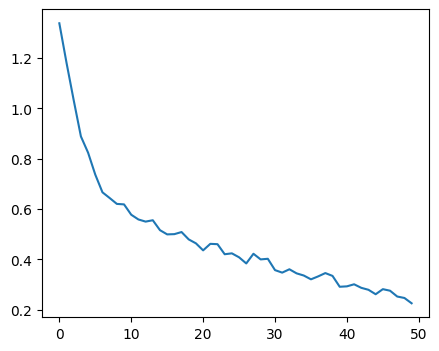

In [ ]:
import seaborn as sns

_, ax = plt.subplots(figsize=(5,4))

sns.lineplot(x=np.arange(len(losses)), y=losses)

##Validation

In [ ]:
predictions = []
targets = []
progress = tqdm(enumerate(test_loader), ncols=100, total=len(test_loader))

for batch_i, (batch_X, batch_y) in progress:

  #batch_X = batch_X.cuda()
  batch_pred = model(batch_X)

  #predictions.extend(np.argmax(batch_pred.detach().cpu().numpy(), axis=1))
  # predictions.extend(batch_pred.detach().numpy())
  # targets.extend(batch_y.detach().numpy())


  predictions.extend(np.argmax(batch_pred.detach().cpu().numpy(),axis=1))
  targets.extend(batch_y.detach().numpy())

predictions = np.array(predictions)
targets = np.array(targets)

print(predictions.shape, targets.shape)


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.70s/it]

(844,) (844,)


numpy.ndarray

Acc: 0.8175355450236966


<Axes: >

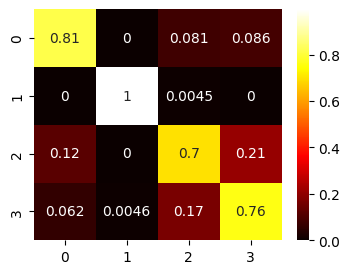

In [ ]:
import seaborn as sns

acc = accuracy_score(targets, predictions)
cm_ = confusion_matrix(targets, predictions)
cmn = cm_ / cm_.sum(axis=1)

print("Acc: {0}".format(acc))
_, ax = plt.subplots(figsize=(4,3))
sns.heatmap(cmn, annot=True, cmap="hot", ax=ax, xticklabels=class_names, yticklabels=class_names)

plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.show()


In [ ]:
import torch
from torchvision import datasets
import matplotlib.pyplot as plt
from collections import Counter

# Cargamos el dataset
image_dataset = test_data

# Contamos las instancias de cada clase
class_counts = Counter([label for _, label in image_dataset.imgs])

# Ordenamos el diccionario por clases para una mejor visualización
class_counts = dict(sorted(class_counts.items()))

# Extraemos las clases y sus respectivas cuentas
classes = list(class_counts.keys())
counts = list(class_counts.values())

# Convertimos los índices de las clases a los nombres reales usando el atributo 'classes' del dataset
class_names = [image_dataset.classes[i] for i in classes]

# Visualizamos la distribución
plt.figure(figsize=(10, 8))
plt.bar(class_names, counts, color='skyblue')
plt.xlabel('Clases')
plt.ylabel('Número de imágenes')
plt.title('Distribución de clases en el conjunto de datos')
plt.xticks(rotation=45)
plt.show()


In [ ]:
normal = pathlib.Path('/content/eye_diseases_data/dataset/normal')
glaucoma = pathlib.Path('/content/eye_diseases_data/dataset/glaucoma')
retinophaty = pathlib.Path('/content/eye_diseases_data/dataset/diabetic_retinopathy')
cataract = pathlib.Path('/content/eye_diseases_data/dataset/cataract')

In [ ]:
images2 = {'normal': list(normal.glob('*.jpg')),
          'glaucoma': list(glaucoma.glob('*jpg')),
          'diabetic_retinopathy': list(retinophaty.glob('*jpg')),
          'cataract' : list(cataract.glob('*jpg'))}

labels2= {
    'normal':0, 'glaucoma':1, 'diabetic_retinopathy':2, 'cataract':3
}

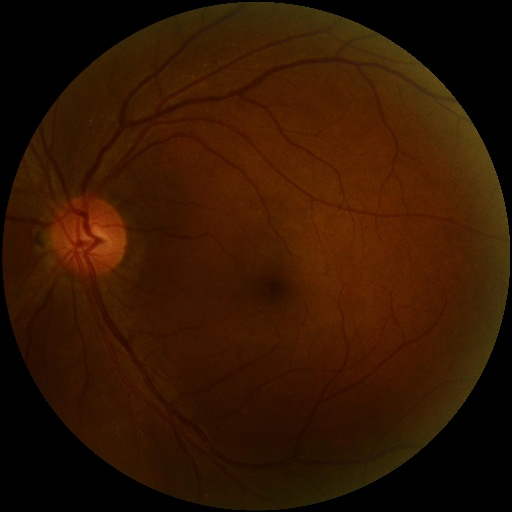

In [ ]:
Image.open(str(images2['normal'][1]))

In [ ]:
img

In [ ]:
X, y = [], []
for label, images in images.items():
  for image in images:
      image = cv2.imread(str(image))
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, (64, 64))
      if image is not None:
        X.append(image)
        y.append(labels[label])



In [ ]:
X = np.array(X)
y = np.array(y)

In [ ]:
X

In [ ]:
X = X/255

In [ ]:
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size = 0.2, random_state=1)

In [ ]:
print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2334, 64, 64, 3) (2334,) (584, 64, 64, 3) (584,)
